In [4]:
import numpy as np
import matplotlib.pyplot as plt
from nba_py import shotchart
from nba_py import player
from matplotlib import colors
import seaborn as sns
%matplotlib inline

In [5]:
from matplotlib.patches import Circle, Rectangle, Arc

# Amazing function by Bradley Fay for plotting the nba court
# source: https://github.com/bradleyfay/py-Goldsberry/blob/master/docs/Visualizing%20NBA%20Shots%20with%20py-Goldsberry.ipynb
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    # Diameter of a hoop is 18" so it has a radius of 9", which is a value
    # 7.5 in our coordinate system
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the side 3pt lines, they are 14ft long before they begin to arc
    corner_three_a = Rectangle((-220, -47.5), 0, 138, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 138, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    # I just played around with the theta values until they lined up with the 
    # threes
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)

    # List of the court elements to be plotted onto the axes
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]

    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -48), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)

    return ax

In [127]:
def create_bins(df, league_average = None, bin_number_x = 25, bin_number_y = 25, \
                width = 500, height = 350, norm_x = 250, norm_y = 48):
    x_bins, y_bins = [], []
    copied_df = df.copy()
    keys = []
    location_counts, location_made = {}, {}
    locations_shots = {} # real locations of shots which will be connected to bins and later arithmetic middle will
                         # be found
    bin_size_x = width / float(bin_number_x)
    locations_annotated = []
    for i in range(len(df)):
        x_shot_orig, y_shot_orig = df.iloc[i].LOC_X, df.iloc[i].LOC_Y
        x_shot = x_shot_orig + norm_x # to put minimum to zero
        y_shot = y_shot_orig + norm_y # to put minimum to zero (.5 is lacking, but just so i can be working with integers)
        
        # bin_index = (x_shot / w) * bin_size
        curr_x_bin = 0 if x_shot == 0 else int((x_shot / float(width)) * bin_number_x)    
        curr_y_bin = 0 if y_shot == 0 else int((y_shot / float(height)) * bin_number_y)
        
        #x_bins.append(curr_bin_x_coord)
        #y_bins.append(curr_bin_y_coord)
        
        key = (curr_x_bin, curr_y_bin)
        keys.append(key)
        if key in location_counts:
            location_counts[key] = location_counts[key] + 1
        else:
            location_counts[key] = 1
        
        if key in location_made:
            location_made[key] = location_made[key] + df.iloc[i].SHOT_MADE_FLAG
        else:
            location_made[key] = df.iloc[i].SHOT_MADE_FLAG
            
        if key in locations_shots:
            locations_shots[key].append((x_shot_orig, y_shot_orig))
        else:
            locations_shots[key] = [(x_shot_orig, y_shot_orig)]
            
        basic_shot_zone, shot_zone_area = df.iloc[i].SHOT_ZONE_BASIC, df.iloc[i].SHOT_ZONE_AREA
        zone_dist = df.iloc[i].SHOT_ZONE_RANGE
        area_code = shot_zone_area.split("(")[1].split(")")[0]
        if "3" in basic_shot_zone:
            locations_annotated.append("3" + area_code)
        elif "Paint" in basic_shot_zone:
            locations_annotated.append("P" + area_code + zone_dist[0])
        elif "Mid" in basic_shot_zone:
            locations_annotated.append("M" + area_code + zone_dist[0])
        else:
            locations_annotated.append("R" + area_code)
        
    shot_locations_percentage = [] # percentage in given bin
    shot_locations_counts = []
    key_x, key_y = [], []
    league_avg_comp = []
    max_shots_at_location = float(max(location_counts.values()))
    max_per_locations = 10.0
    for j in range(len(df)):
        key = keys[j]
        shot_percent = float(location_made[key]) / location_counts[key]
        #shot_percent = np.clip(shot_percent, 0.3, 0.7)
        shot_locations_percentage.append(shot_percent * 100)
        if league_average is not None:
            shot_zone_basic, shot_zone_area = df.iloc[i].SHOT_ZONE_BASIC, df.iloc[i].SHOT_ZONE_AREA
            distance = df.iloc[i].SHOT_ZONE_RANGE
            avg_percentage = league_average.loc[(league_average.SHOT_ZONE_BASIC == shot_zone_basic) & \
                                                (league_average.SHOT_ZONE_AREA == shot_zone_area) & \
                                               (league_average.SHOT_ZONE_RANGE == distance)].FG_PCT
            league_avg_comp.append(np.clip((shot_percent - avg_percentage) * 100, -20, 20))
        
        
        #scaled_count = np.clip(location_counts[key] / max_shots_at_location * max_per_locations, 1, max_per_locations)
        shot_locations_counts.append(np.clip(location_counts[key], 1, 20))
        #shot_locations_counts.append(location_counts[key])
        
        all_x_locs = [x_loc for x_loc, y_loc in locations_shots[key]]
        all_y_locs = [y_loc for x_loc, y_loc in locations_shots[key]]
        
        #x_bins.append(np.random.normal(np.mean(all_x_locs), scale=np.std(all_x_locs)))
        #y_bins.append(np.random.normal(np.mean(all_y_locs), scale=np.std(all_y_locs)))
        
        x_bins.append(np.mean(all_x_locs))
        y_bins.append(np.mean(all_y_locs))
        
        key_x.append(key[0])
        key_y.append(key[1])
        
    copied_df['BIN_LOC_X'] = x_bins
    copied_df['BIN_LOC_Y'] = y_bins
    if league_average is not None:
        copied_df['PCT_LEAGUE_AVG_COMPARISON'] = league_avg_comp
    copied_df['LOC_PERCENTAGE'] = shot_locations_percentage
    copied_df['LOC_COUNTS'] = shot_locations_counts
    copied_df['BIN_X'] = key_x
    copied_df['BIN_Y'] = key_y
    copied_df['LOCATION_CODE'] = locations_annotated
    
    return copied_df
    

In [7]:
plt.style.use('fivethirtyeight')

In [75]:
# setting up data
season = "2016-17"
player_name = "Kevin"
player_surname = "Love"
player_id = player.get_player(player_name, player_surname, season=season)
player_data = shotchart.ShotChart(player_id=player_id, season=season)
league_average = player_data.league_average()

In [76]:
player_df = player_data.shot_chart()
player_df.LOC_X = -player_df.LOC_X # REAL DATA IS FLIPPED
player_df = player_df.loc[(player_df.SHOT_ZONE_AREA != "Back Court(BC)") & (player_df.LOC_Y < 300)] # drop shots that aren't close to the center
len(player_df)

867

In [19]:
league_average

,GRID_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,FGA,FGM,FG_PCT
0,League Averages,Above the Break 3,Back Court(BC),Back Court Shot,63,4,0.063
1,League Averages,Above the Break 3,Center(C),24+ ft.,13187,4648,0.352
2,League Averages,Above the Break 3,Left Side Center(LC),24+ ft.,18579,6513,0.351
3,League Averages,Above the Break 3,Right Side Center(RC),24+ ft.,18244,6434,0.353
4,League Averages,Backcourt,Back Court(BC),Back Court Shot,499,10,0.020
5,League Averages,In The Paint (Non-RA),Center(C),8-16 ft.,7159,3069,0.429
6,League Averages,In The Paint (Non-RA),Center(C),Less Than 8 ft.,18654,7727,0.414
7,League Averages,In The Paint (Non-RA),Left Side(L),8-16 ft.,1919,778,0.405
8,League Averages,In The Paint (Non-RA),Right Side(R),8-16 ft.,2091,879,0.420
9,League Averages,Left Corner 3,Left Side(L),24+ ft.,8031,3102,0.386


In [10]:
def get_shotchart_for_players(players):
    final_data = None
    season = "2017-18"
    for curr_player in players:
        name, surname = curr_player[0], curr_player[1]
        print name, surname
        curr_id = player.get_player(name, surname, season=season)
        player_data = shotchart.ShotChart(player_id=curr_id, season=season)
        player_data = player_data.shot_chart()
        player_data.LOC_X = -player_data.LOC_X # REAL DATA IS FLIPPED
        player_data = player_data.loc[(player_data.SHOT_ZONE_AREA != "Back Court(BC)") & (player_data.LOC_Y < 300)]
        if final_data is None:
            final_data = player_data
        else:
            final_data = final_data.append(player_data)
    return final_data

In [11]:
gsw_players = [["Kevin", "Durant"], ["Klay","Thompson"], ["Stephen", "Curry"]]
rockets_players = [["James", "Harden"], ["Ryan","Anderson"], ["Eric", "Gordon"]]

gsw_data, rockets_data = get_shotchart_for_players(gsw_players), get_shotchart_for_players(rockets_players)

Kevin Durant
Klay Thompson
Stephen Curry
James Harden
Ryan Anderson
Eric Gordon


In [12]:
print len(gsw_data)
print len(rockets_data)

537
498


In [128]:
binned_df = create_bins(player_df, league_average=league_average, bin_number_x=30, bin_number_y=30)

In [129]:
cleared_df = binned_df
cleared_df = binned_df.loc[binned_df.LOC_COUNTS>1]

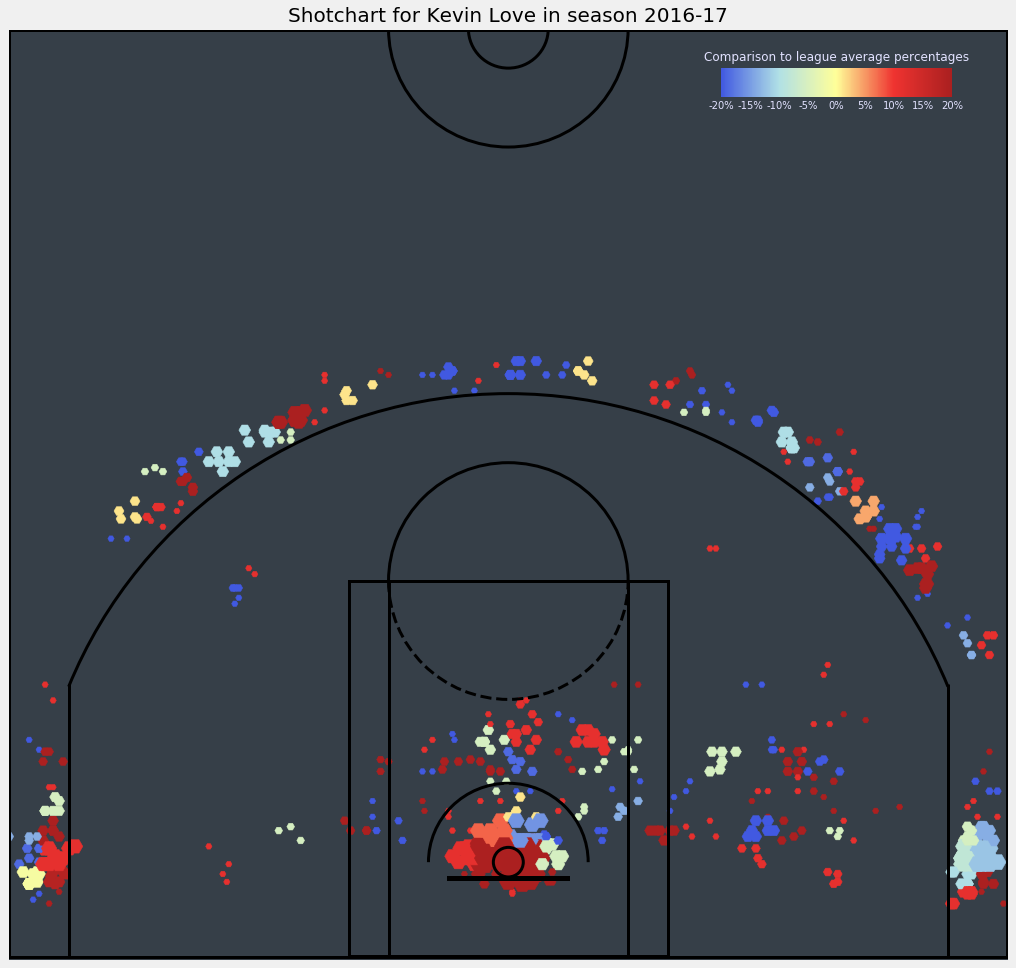

In [145]:
fig = plt.figure(figsize=(16, 16))
#colors_dict = {0:'red', 1:'green'}
cmap = sns.blend_palette(colors=["#4159E1", "#B0E0E6", "#FFFF99","#EF3330", "#AB2020"], as_cmap=True)

#LOC_PERCENTAGE
plt.scatter(x=cleared_df.LOC_X, y=cleared_df.LOC_Y, marker='H', s= 20* cleared_df.LOC_COUNTS, c=cleared_df.PCT_LEAGUE_AVG_COMPARISON, cmap=cmap)

"""for i in range(len(cleared_df)):
    if cleared_df.iloc[i].LOCATION_CODE == "3C" or cleared_df.iloc[i].LOCATION_CODE == "RC":
        plt.text(x=cleared_df.iloc[i].LOC_X, y=cleared_df.iloc[i].LOC_Y, s=cleared_df.iloc[i].LOCATION_CODE, color="#E2E2FF")"""
            

#plt.xticks(np.arange(-250, 251, 10))
#plt.yticks(np.arange(-50, 400, 10))
#plt.grid(b=True)

# Changing court color
plt.gca().set_facecolor('#363F48')
curr_ax = plt.gca()

# Removing ticks
plt.xticks([])
plt.yticks([])

# Title
plt.title("Shotchart for Kevin Love in season " + season, size=20)

# Drawing court
draw_court(outer_lines=True, lw=3)
plt.xlim(-251,251)
plt.ylim(-50,423)

# Colorbar
cax = fig.add_axes([0.7, 0.82, 0.2, 0.025])
colorbar = plt.colorbar(cax=cax, orientation='horizontal', format='%d%%')
#colorbar = plt.colorbar(cax=cax, orientation='horizontal', format='%+d%%') # + is for positive percentage
cax.set_xlabel("Comparison to league average percentages",
            fontsize=12, labelpad=-60, color="#E2E2FF")
colorbar.outline.set_visible(False)
plt.setp(plt.getp(colorbar.ax.axes, 'xticklabels'), color="#E2E2FF", fontsize=10)

# Saving figure
#plt.savefig('lebron.png', bbox_inches='tight')
#colorbar.set_label('Comparison to league average percentages', color='#E2E2FF', size=16, coords=(1.5, 1.5))
plt.show()

In [17]:
for location_code in cleared_df.LOCATION_CODE.unique().tolist():
    print "For Location: " + location_code
    print "\tMinimum: (" + str(cleared_df.loc[cleared_df.LOCATION_CODE == location_code].min().LOC_X) \
                       + "," + str(cleared_df.loc[cleared_df.LOCATION_CODE == location_code].min().LOC_Y) + ")"
    print "\tMaximum: (" + str(cleared_df.loc[cleared_df.LOCATION_CODE == location_code].max().LOC_X) \
                       + "," + str(cleared_df.loc[cleared_df.LOCATION_CODE == location_code].max().LOC_Y) + ")"

For Location: 3RC
	Minimum: (-230,105)
	Maximum: (-79,246)
For Location: RC
	Minimum: (-35,-24)
	Maximum: (30,36)
For Location: 3L
	Minimum: (223,-19)
	Maximum: (248,44)
For Location: 3R
	Minimum: (-248,-11)
	Maximum: (-223,80)
For Location: MR
	Minimum: (-200,-31)
	Maximum: (-82,121)
For Location: ML
	Minimum: (81,-21)
	Maximum: (197,115)
For Location: MRC
	Minimum: (-163,100)
	Maximum: (-53,203)
For Location: 3LC
	Minimum: (83,92)
	Maximum: (232,262)
For Location: 3C
	Minimum: (-76,232)
	Maximum: (78,278)
For Location: MC
	Minimum: (-76,139)
	Maximum: (48,213)
For Location: PR
	Minimum: (-79,33)
	Maximum: (-51,111)
For Location: MLC
	Minimum: (68,116)
	Maximum: (176,183)
For Location: PC
	Minimum: (-74,2)
	Maximum: (78,136)
